# Mount GDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip3 install keras-self-attention

  Stored in directory: /root/.cache/pip/wheels/40/fc/a7/5df49ef3cbfcdb217fa3990d047f637f0b2bdc287373f53729
Successfully built keras-self-attention


# Import libraries

In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras import initializers, regularizers, constraints, optimizers, layers
from keras_self_attention import SeqSelfAttention
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


# Import data from GDrive

In [0]:
path =  "gdrive/My Drive/Colab Notebooks/Toxic Comments/"

In [0]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
test_labels = pd.read_csv(path + 'test_labels.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

# Preprocessing

Check for null values.

In [6]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

# Tokenize text

We tokenize words and sentences.

We need to identify ideal max length `maxlen` for sentence as well as max num of features `max_features`.

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [0]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

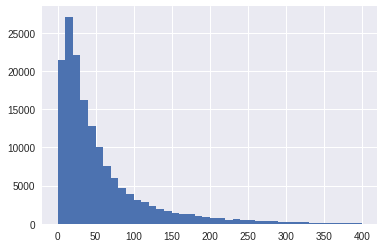

In [10]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [0]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

# Define helper methods

Define ROC AOC and a method for plotting train and validation loss.

In [0]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [0]:
def plot_history(hs, epochs):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history['loss'], label='{0:s} train loss'.format(label))
        plt.plot(hs[label].history['val_loss'], label='{0:s} validation loss'.format(label))
    x_ticks = np.arange(0, epochs + 1, epochs / 5)
    x_ticks [0] += 1
    plt.xticks(x_ticks-1, ('1', '1', '2', '3', '4', '5'))
    plt.ylim((0, 0.1))
    plt.xlabel('Epochs')
    plt.ylabel('binary crossentropy')
    plt.legend()
    plt.show()

# Compiling the model

In [0]:
def compile_model(dropout=0.2, lr=0.1):
  inp = Input(shape=(maxlen, ))
  embed_size = 128
  x = Embedding(max_features, embed_size)(inp)
  x = CuDNNLSTM(128, return_sequences=True)(x)
  x = Dropout(dropout)(x)
  x = SeqSelfAttention()(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(6, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
  return model

# Split train data

We split train data into train, held-out and validation data.

In [15]:
X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.9)
X_tra, X_hel, y_tra, y_hel = train_test_split(X_tra, y_tra, train_size=0.9)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Hyper-parameter tuning for learning rate

In [17]:
epochs = 1
batch_size = 32
RocAuc = RocAucEvaluation(validation_data=(X_hel, y_hel), interval=1)

for i in range(1, 5):
  lr = i/1000
  model = compile_model(lr=lr)
  print("Learning rate: {:.3f}".format(lr))
  history = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_hel, y_hel),
                 callbacks=[RocAuc], verbose=2)

Learning rate: 0.001
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 325s - loss: 0.0672 - acc: 0.9781 - val_loss: 0.0505 - val_acc: 0.9817

 ROC-AUC - epoch: 1 - score: 0.974436
Learning rate: 0.002
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 320s - loss: 0.0642 - acc: 0.9785 - val_loss: 0.0505 - val_acc: 0.9818

 ROC-AUC - epoch: 1 - score: 0.976452
Learning rate: 0.003
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 324s - loss: 0.0633 - acc: 0.9784 - val_loss: 0.0513 - val_acc: 0.9815

 ROC-AUC - epoch: 1 - score: 0.975658
Learning rate: 0.004
Train on 129251 samples, validate on 14362 samples
Epoch 1/1


KeyboardInterrupt: ignored

# Early stopping

In [18]:
epochs = 5

model = compile_model(lr=0.002)

RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

history = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=2)

Train on 129251 samples, validate on 15958 samples
Epoch 1/5
 - 323s - loss: 0.0676 - acc: 0.9773 - val_loss: 0.0484 - val_acc: 0.9826

 ROC-AUC - epoch: 1 - score: 0.974193
Epoch 2/5
 - 322s - loss: 0.0442 - acc: 0.9832 - val_loss: 0.0474 - val_acc: 0.9831

 ROC-AUC - epoch: 2 - score: 0.977139
Epoch 3/5
 - 323s - loss: 0.0388 - acc: 0.9848 - val_loss: 0.0477 - val_acc: 0.9832

 ROC-AUC - epoch: 3 - score: 0.980601
Epoch 4/5
 - 322s - loss: 0.0343 - acc: 0.9864 - val_loss: 0.0479 - val_acc: 0.9834

 ROC-AUC - epoch: 4 - score: 0.980343
Epoch 5/5
 - 323s - loss: 0.0303 - acc: 0.9880 - val_loss: 0.0517 - val_acc: 0.9830

 ROC-AUC - epoch: 5 - score: 0.977250


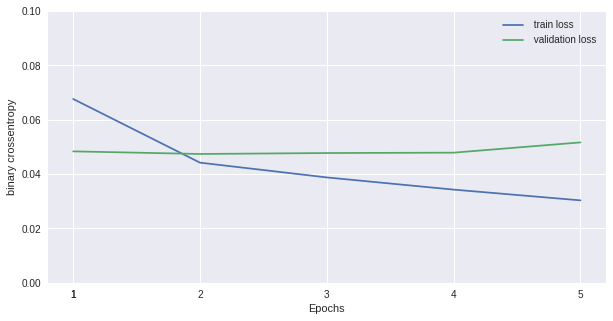

In [19]:
plot = plot_history(hs={'': history}, epochs=epochs)

# Train final model

Use full training set with the final parameters

In [21]:
model = compile_model(lr=0.002)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 200, 128)          132096    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
seq_self_attention_8 (SeqSel (None, 200, 128)          8257      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total para

In [22]:
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs)

Epoch 1/2
159571/159571 [==============================] - 404s 3ms/step - loss: 0.0616 - acc: 0.9789
Epoch 2/2
159571/159571 [==============================] - 400s 3ms/step - loss: 0.0440 - acc: 0.9834


# Predict test

In [23]:
predictions = model.predict(X_te, batch_size=batch_size, verbose=1)

153164/153164 [==============================] - 128s 835us/step


# Save predictions for submission

In [0]:
sample_submission[list_classes] = predictions

In [0]:
sample_submission.to_csv(path + 'submission.csv', index=False)